In [46]:
library(igraph)

# Grow function with preferential attachment
grow_network <- function(g, steps, new_edges_per_step, results_df, preferential_attachment = TRUE) {
    for (i in 1:steps) {
        kmean <- mean(degree(g))
        ncc <- length(components(g)$csize)
        gcc <- induced_subgraph(g, which(components(g)$membership == which.max(components(g)$csize)))
        density <- edge_density(g)
        av.len.path <- mean_distance(gcc)
        clust.coef <- transitivity(g, type = "average")
        gcc.size <- max(components(g)$csize)


        # Append results to the dataframe
        results_df <- rbind(results_df, data.frame(
          mean_degree = kmean,
          number_cc = ncc,                                         
          density = density,
          avg_path_length = av.len.path,
          clustering_coefficient = clust.coef,
          gcc_size = gcc.size,
          stringsAsFactors = FALSE
        ))

        # Add a new node
        new_node <- vcount(g) + 1
        g <- add_vertices(g, 1)

        # Ensure there are nodes to connect to and correct probability vector
        if (vcount(g) > 1) {
            existing_nodes <- V(g)[-new_node]
            degrees <- degree(g)[existing_nodes]
        
            if (preferential_attachment) {
                # Preferential attachment: Connect the new node to existing nodes based on their degree
                degrees <- degree(g)[existing_nodes]
                if (all(degrees == 0)) {
                    # If all degrees are zero, use uniform probabilities
                    prob <- rep(1 / length(existing_nodes), length(existing_nodes))
            } else {
                # Degree based probabilities 
                prob <- degrees / sum(degrees)
            }
} else {
    # Uniform probability: random attachment
    prob <- rep(1 / length(existing_nodes), length(existing_nodes))
}

            target_nodes <- sample(existing_nodes, new_edges_per_step, prob = prob, replace = FALSE)
            g <- add_edges(g, c(rbind(new_node, target_nodes)))
        }
    }
    return(list(graph = g, results = results_df, prob = prob))
}

# Shrink function 
shrink_network <- function(g, steps, results_df) {
    for (i in 1:steps) {
        kmean <- mean(degree(g))
        ncc <- length(components(g)$csize)
        gcc <- induced_subgraph(g, which(components(g)$membership == which.max(components(g)$csize)))
        density <- edge_density(g)
        av.len.path <- mean_distance(gcc)
        clust.coef <- transitivity(g, type = "average")
        gcc.size <- max(components(g)$csize)

    
        results_df <- rbind(results_df, data.frame(
          mean_degree = kmean,
          number_cc = ncc,                                         
          density = density,
          avg_path_length = av.len.path,
          clustering_coefficient = clust.coef,
          gcc_size = gcc.size,
          stringsAsFactors = FALSE
        ))  
        
        #Delete a random node and its connections
        
        if (vcount(g) > 0) {
            node_to_remove <- sample(V(g), 1)
            g <- delete_vertices(g, node_to_remove) 
        }
    }
    return(list(graph = g, results = results_df))
}

# Define a function that simulates the growth and shrink of a network
growth_shrink_er <- function(initial_nodes, initial_prob, growth_steps, shrink_steps, edges_per_step) {
    g <- erdos.renyi.game(initial_nodes, p = initial_prob, directed = FALSE)

    results_df <- data.frame(
      mean_degree = numeric(),
      number_cc = numeric(),
      density = numeric(),
      avg_path_length = numeric(),
      clustering_coefficient = numeric(),
      gcc_size = numeric(),
      stringsAsFactors = FALSE
    )

    #Grow phase
    grow <- grow_network(g, growth_steps, edges_per_step, results_df)
    g.grow <- grow$graph
    results.grow <- grow$results

    #Shrink phase
    shrink <- shrink_network(g.grow, shrink_steps, results.grow)
    g.shrink <- shrink_results$graph
    results.total <- shrink_results$results

    return(list(g.grow = g.grow, g.shrink = g.shrink, results = results.total))
}




In [34]:
# Define parameter sets for small and large initial networks
params_small <- list(
    list(initial_nodes = 100, initial_prob = 0.01, growth_steps = 500, shrink_steps = 500, edges_per_step = 2),
    list(initial_nodes = 100, initial_prob = 0.05, growth_steps = 500, shrink_steps = 500, edges_per_step = 2),
    list(initial_nodes = 100, initial_prob = 0.05, growth_steps = 500, shrink_steps = 500, edges_per_step = 10)
)

params_large <- list(
    list(initial_nodes = 300, initial_prob = 0.01, growth_steps = 1500, shrink_steps = 1500, edges_per_step = 2),
    list(initial_nodes = 300, initial_prob = 0.05, growth_steps = 1500, shrink_steps = 1500, edges_per_step = 2),
    list(initial_nodes = 300, initial_prob = 0.05, growth_steps = 1500, shrink_steps = 1500, edges_per_step = 10)
)

# Function to run simulations and store results
run_simulations <- function(params) {
  results_list <- list()
  for (i in 1:length(params)) {
    param_set <- params[[i]]
    result <- growth_shrink_er(
      initial_nodes = param_set$initial_nodes,
      initial_prob = param_set$initial_prob,
      growth_steps = param_set$growth_steps,
      shrink_steps = param_set$shrink_steps,
      edges_per_step = param_set$edges_per_step
    )
    results_list[[i]] <- list(parameters = param_set, results = result$results)
  }
  return(results_list)
}

# Run simulations for small and large initial networks
results_small <- run_simulations(params_small)
results_large <- run_simulations(params_large)


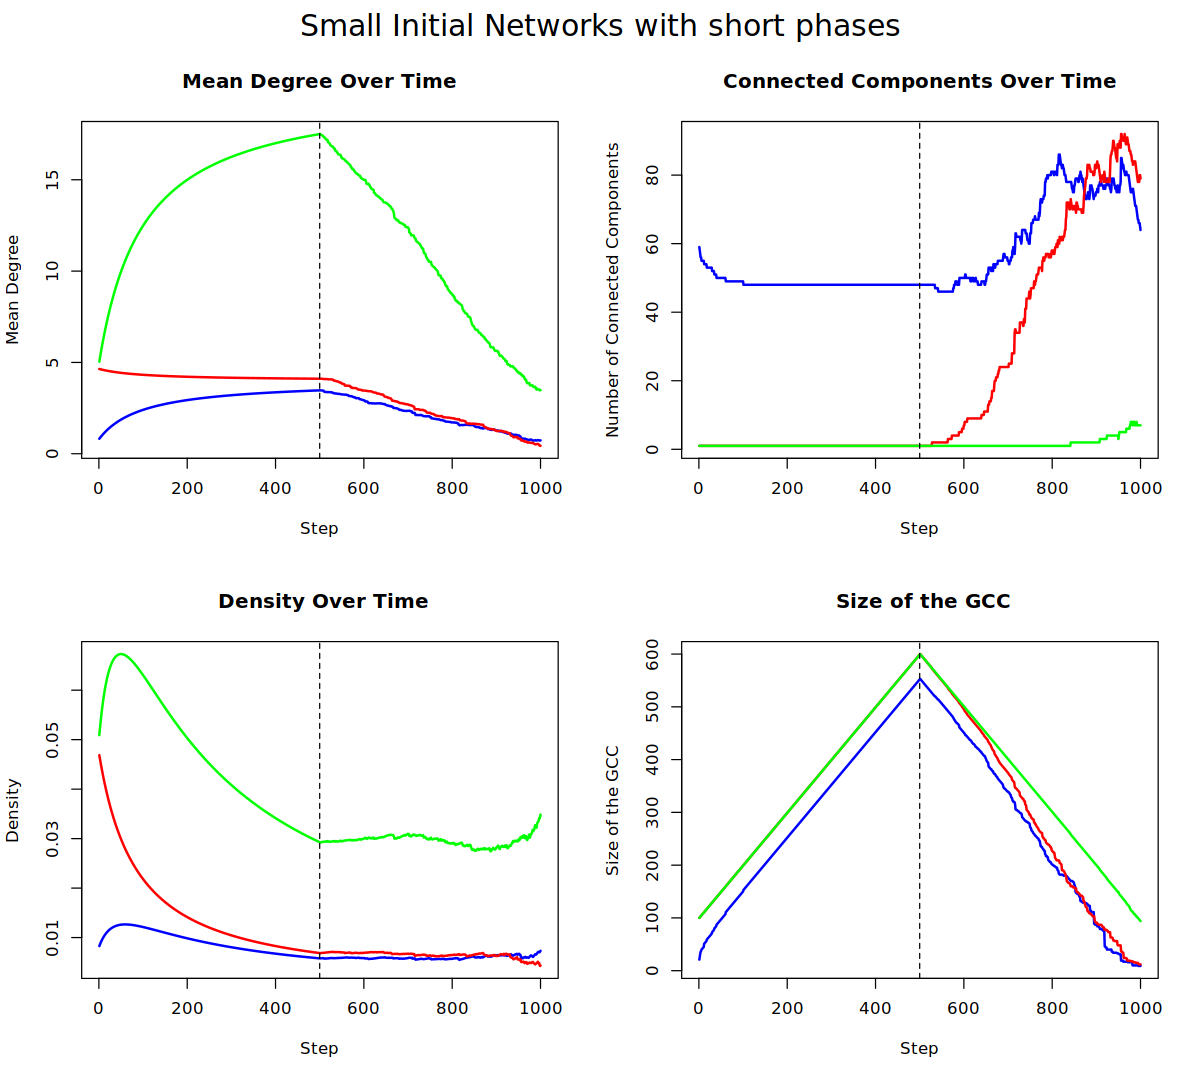

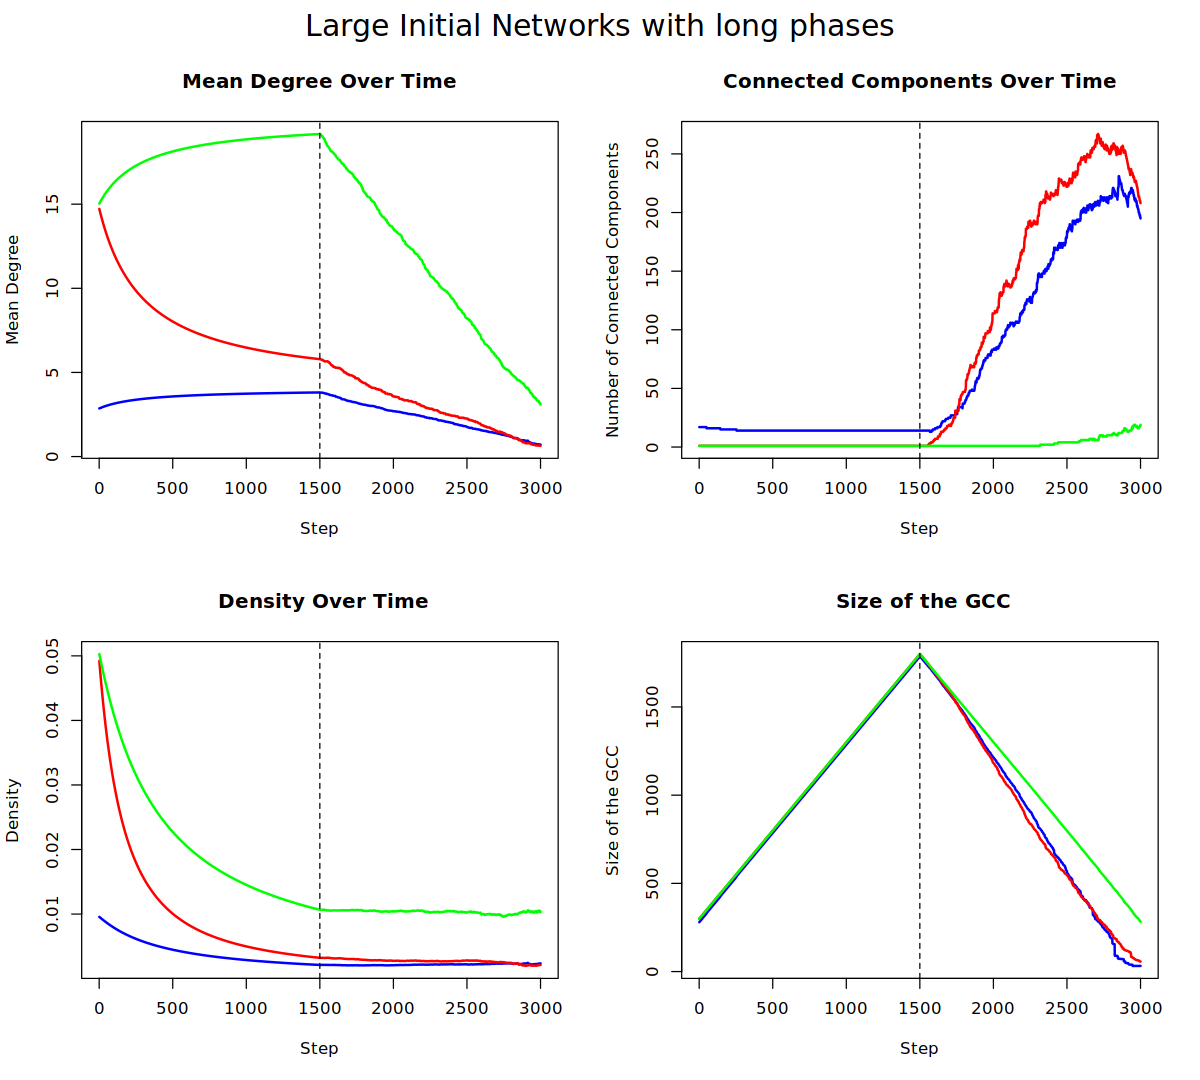

In [107]:
# Function to plot results for each group
plot_combined_results <- function(results_list, title_prefix) {

    options(repr.plot.width = 10, repr.plot.height = 9)
    par(mfrow = c(2, 2), oma = c(0, 0, 2, 0)) # Set up the plotting area for 6 plots

    colors <- c("blue", "red", "green") # Colors for different parameter sets

    # Plot Mean Degree Over Time
    plot(NULL, xlim = c(1, max(sapply(results_list, function(r) nrow(r$results)))), ylim = range(sapply(results_list, function(r) range(r$results$mean_degree))),
       xlab = "Step", ylab = "Mean Degree", main = "Mean Degree Over Time")
    for (i in 1:length(results_list)) {
        lines(results_list[[i]]$results$mean_degree, col = colors[i], lwd = 2)
    }
    abline(v = results_list[[1]]$parameters$growth_steps, col = "black", lty = 2)

    # Plot Number of Connected Components Over Time
    plot(NULL, xlim = c(1, max(sapply(results_list, function(r) nrow(r$results)))), ylim = range(sapply(results_list, function(r) range(r$results$number_cc))),
       xlab = "Step", ylab = "Number of Connected Components", main =  "Connected Components Over Time")
    for (i in 1:length(results_list)) {
        lines(results_list[[i]]$results$number_cc, col = colors[i], lwd = 2)
    }
    abline(v = results_list[[1]]$parameters$growth_steps, col = "black", lty = 2)

    # Plot Density Over Time
    plot(NULL, xlim = c(1, max(sapply(results_list, function(r) nrow(r$results)))), ylim = range(sapply(results_list, function(r) range(r$results$density))),
        xlab = "Step", ylab = "Density", main = " Density Over Time")
    for (i in 1:length(results_list)) {
        lines(results_list[[i]]$results$density, col = colors[i], lwd = 2)
    }
    abline(v = results_list[[1]]$parameters$growth_steps, col = "black", lty = 2)

     # Plot Average Path Length Over Time
    #plot(NULL, xlim = c(1, max(sapply(results_list, function(r) nrow(r$results)))), ylim = range(sapply(results_list, function(r) range(r$results$avg_path_length))),
    #    xlab = "Step", ylab = "Average Path Length", main = " Avg Path Length Over Time")
    #for (i in 1:length(results_list)) {
     #   lines(results_list[[i]]$results$avg_path_length, col = colors[i], lwd = 2)
    #}
    #abline(v = results_list[[1]]$parameters$growth_steps, col = "black", lty = 2)

    # Plot Clustering Coefficient Over Time
    #plot(NULL, xlim = c(1, max(sapply(results_list, function(r) nrow(r$results)))), ylim = range(sapply(results_list, function(r) range(r$results$clustering_coefficient))),
     #   xlab = "Step", ylab = "Clustering Coefficient", main = "Clustering Coefficient Over Time")
    #for (i in 1:length(results_list)) {
     #   lines(results_list[[i]]$results$clustering_coefficient, col = colors[i], lwd = 2)
    #}
    #abline(v = results_list[[1]]$parameters$growth_steps, col = "black", lty = 2)

    # Plot Size of the Giant Connected Component (GCC) Over Time
    plot(NULL, xlim = c(1, max(sapply(results_list, function(r) nrow(r$results)))), ylim = range(sapply(results_list, function(r) range(r$results$gcc_size))),
       xlab = "Step", ylab = "Size of the GCC", main = " Size of the GCC")
    for (i in 1:length(results_list)) {
        lines(results_list[[i]]$results$gcc_size, col = colors[i], lwd = 2)
    }
    abline(v = results_list[[1]]$parameters$growth_steps, col = "black", lty = 2)

    mtext(title_prefix, outer = TRUE, cex = 1.5)

}

# Plot combined results for small and large networks
plot_combined_results(results_small, "Small Initial Networks with short phases")
plot_combined_results(results_large, "Large Initial Networks with long phases")

# Reset plotting area
par(mfrow = c(1, 1))


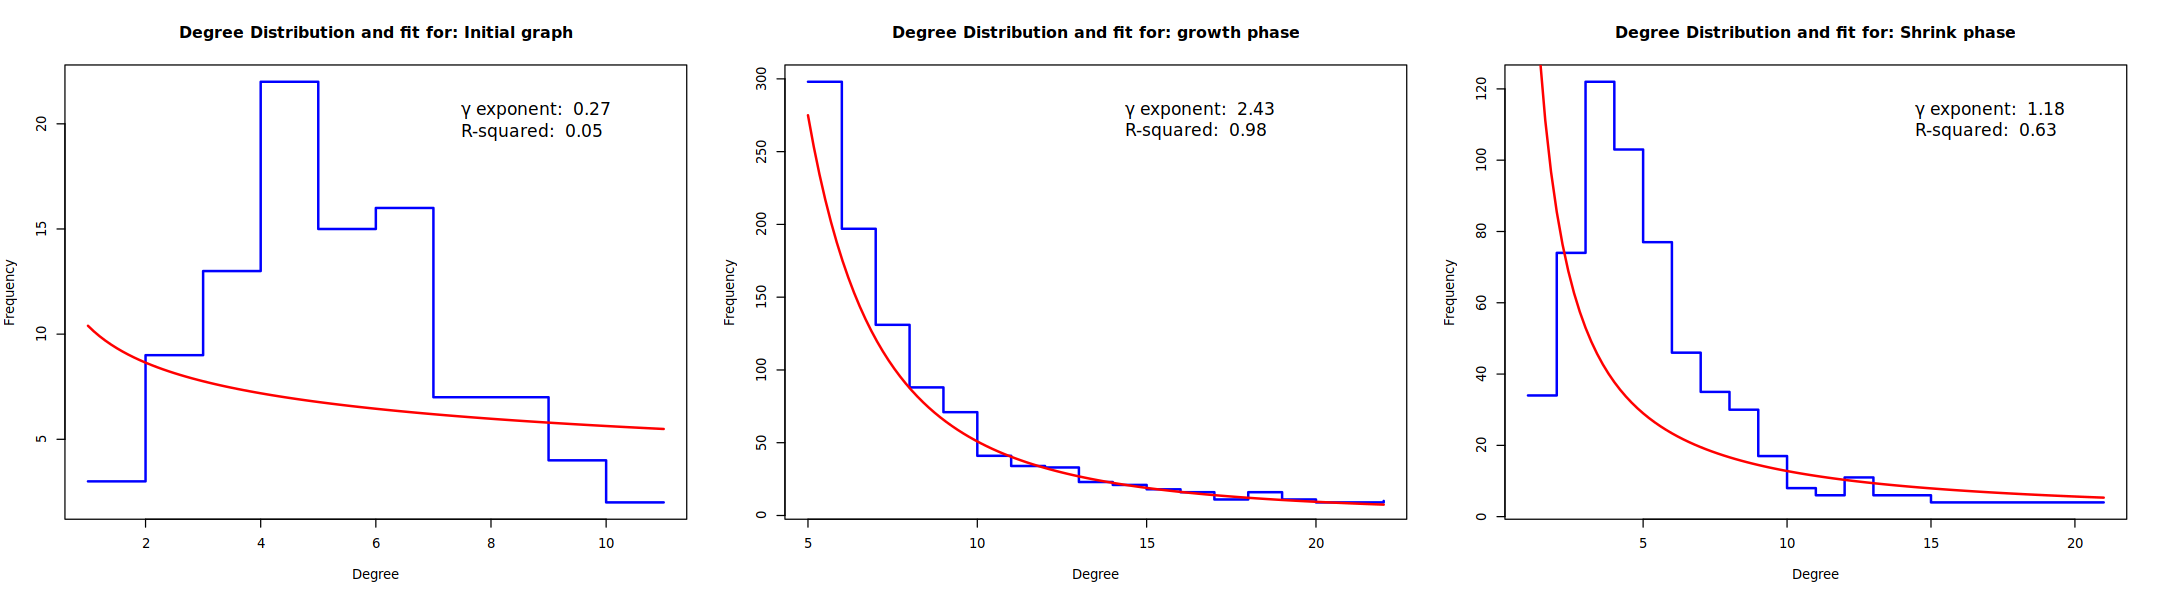

In [69]:
visualization_degree_distr <- function(g, min_count, grow_shrink) {

    degrees <- degree(g)  # Degree of each node in the network

    # Calculate the degree distribution
    degree_counts <- table(degrees) 
    degree_values <- as.numeric(names(degree_counts))
    degree_frequencies <- as.numeric(degree_counts)

    # Filter out degrees with counts below the threshold
    degree_values <- degree_values[degree_frequencies >= min_count]
    degree_frequencies <- degree_frequencies[degree_frequencies >= min_count]

    # Further filter out degrees and frequencies less than or equal to 0
    valid_indices <- which(degree_values > 0 & degree_frequencies > 0)
    degree_values <- degree_values[valid_indices]
    degree_frequencies <- degree_frequencies[valid_indices]

    # Ensure that there are enough points for fitting
    if (length(degree_values) > 1) {
      # Perform a linear fit on the log-transformed data to estimate power-law exponent
      log_degree_values <- log(degree_values)
      log_degree_frequencies <- log(degree_frequencies)
      fit <- lm(log_degree_frequencies ~ log_degree_values)

      # Extract the slope of the line, which is the negative of the power-law exponent
      exponent <- -coef(fit)[2]

      # Plot histogram of degrees in step mode (not log scale)
      plot(degree_values, degree_frequencies, type= 's', col = "blue", lwd = 2,
       xlab = "Degree", ylab = "Frequency",
       main = paste0("Degree Distribution and fit for: ", grow_shrink))

      # Overlay the fitted power-law curve
      curve(exp(fit$coefficients[1] + fit$coefficients[2] * log(x)), 
            from = min(degree_values), to = max(degree_values), 
            add = TRUE, col = "red", lwd = 2)

      # Display the power-law exponent and R-squared value on the plot
      legend(max(degree_values) * 0.5, max(degree_frequencies) * 0.98, legend = c(paste("\u03B3 exponent: ", round(exponent, 2)),
                                paste("R-squared: ", round(summary(fit)$r.squared, 2))),
            cex=1.3, bty = "n", y.intersp = 1.5)
    } else {
      print("Not enough data points for fitting.")
    }
}

# Parameters
initial.nodes <- 100
growth.steps <- 1000
shrink.steps <- 500
edges.per.step <- 5

# Initialize the network (empty graph)
G.initial <- erdos.renyi.game(initial.nodes, p = 0.05, directed = FALSE)

# Initialize results data frame
results_df <- data.frame(
  mean_degree = numeric(),
  number_cc = numeric(),
  density = numeric(),
  avg_path_length = numeric(),
  clustering_coefficient = numeric(),
  gcc_size = numeric(),
  stringsAsFactors = FALSE
)

# Perform the growth phase
growth_results <- grow_network(G.initial, growth.steps, edges.per.step, results_df, preferential_attachment = TRUE)
G.grow <- growth_results$graph
results.grow <- growth_results$results


# Perform the shrink phase
shrink_results <- shrink_network(G.grow, shrink.steps, results.grow)
G.shrink <- shrink_results$graph
results <- shrink_results$results

options(repr.plot.width = 18, repr.plot.height = 5)
par(mfrow = c(1,3))

P.k.initial <- visualization_degree_distr(G.initial, 1, "Initial graph")
P.k.growth <- visualization_degree_distr(G.grow, 7, "growth phase")
P.k.shrink <- visualization_degree_distr(G.shrink, 3, "Shrink phase")

